# Project 1: Analyzing SAT Scores and the Cost Efficiency of SAT Prep Programs

## Part 1: Plot the percentage of students meeting both SAT benchmarks grouped by county.

### My hypothesis is that the percentage of students meeting both benchmarks will vary to a large degree by county

In [1]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# modeling imports
from sklearn.linear_model import LinearRegression
from sklearn import metrics
plt.style.use('default')

In [2]:
#load in data
ca_full = pd.read_csv('./data/sat_2019_ca.csv')

# create new dataframe with only the columns we need
ca = ca_full[['SName', 'CName', 'PctBothBenchmark12', 'PctBothBenchmark11']]

# remove rows with null values
ca = ca.dropna(axis=0, subset=['SName','PctBothBenchmark12','PctBothBenchmark11'])

# a lot of rows have the character '*'. Let's remove those rows
ca = ca[ca.PctBothBenchmark11 != '*']
ca = ca[ca.PctBothBenchmark12 != '*']

# rename columns to something better
ca.columns = ['school_name', 'county_name', 'pct_bench_12', 'pct_bench_11']

#here is the clean dataframe
ca.head()

,school_name,county_name,pct_bench_12,pct_bench_11
2,Belmont Senior High,Los Angeles,13.73,6.32
3,Canoga Park Senior High,Los Angeles,15.93,12.73
5,Foshay Learning Center,Los Angeles,33.96,24.04
6,Mission Viejo High,Orange,69.47,77.13
9,New Open World Academy K-12,Los Angeles,8.82,7.59


In [3]:
# here is the clean dataframe's shape
ca.shape

(1199, 4)

In [4]:
# the datatypes of ca are wrong, lets fix them
ca.dtypes

school_name     object
county_name     object
pct_bench_12    object
pct_bench_11    object
dtype: object

In [5]:
# use to_numeric to change the number columns to float
ca['pct_bench_11'] = pd.to_numeric(ca['pct_bench_11'])
ca['pct_bench_12'] = pd.to_numeric(ca['pct_bench_12'])

### The ca dataframe is ready for analysis and plotting

In [6]:
#add a column that is the average of pct_bench_11 and pct_bench_12
ca['pct_bench_avg'] = (ca['pct_bench_11']+ca['pct_bench_12'])/2

In [7]:
#create series with the grouped data that we would like to plot
pct_bench_avg_by_county = ca.groupby('county_name')['pct_bench_avg'].mean()
pct_bench_avg_by_county = pct_bench_avg_by_county.sort_values(axis = 0)

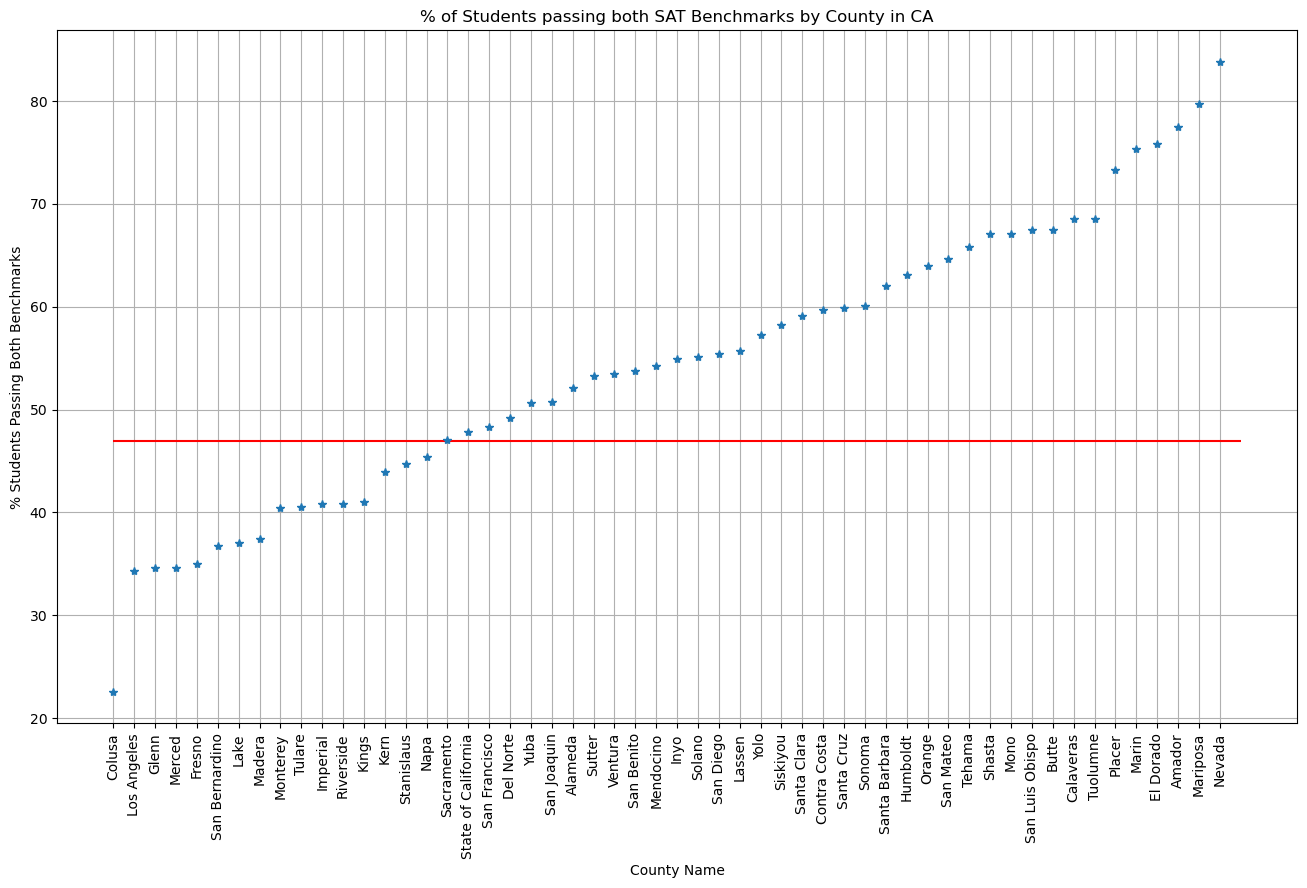

In [8]:
#create plot
myfig = plt.figure(figsize = (16,9))
plt.plot(pct_bench_avg_by_county, marker = '*', linestyle = 'none')
plt.grid()
plt.title('% of Students passing both SAT Benchmarks by County in CA')
plt.xlabel('County Name')
plt.ylabel('% Students Passing Both Benchmarks')
plt.xticks(rotation = 90)
plt.hlines(ca['pct_bench_avg'].mean(),0,len(pct_bench_avg_by_county), color = 'red');
plt.savefig('%studentsbycounty.png', bbox_inches = 'tight', dpi=myfig.dpi)

This plot shows that the percentage of students passing both SAT benchmarks varies widely in California. Calusa county comes in at just over 20% of students whereas Nevada county tops 80%. The mean school has a passing rate of 47%. 

Now we have established there are disadvantaged counties when it comes to SAT scores in California. Why are SAT scores important? Could state-funded SAT prep classes be advisable in disadvantaged counties? These are the next questions to address in this analysis.

## Part 2: Measure the importance of SAT Scores. Analyze the relationship between college acceptance rates and the SAT scores of accepted students

### Import sat_act_by-_college and clean data

In [9]:
#load in data
college_full = pd.read_csv('./data/sat_act_by_college.csv')

# create new dataframe with only the columns we need
college = college_full[['School', 'Accept Rate', 'SAT Total 25th-75th Percentile']]

# rename columns to something better
college.columns = ['school', 'accept_rate', 'pct2575']

# remove rows with null values
college = college.dropna(axis=0, subset=['school', 'accept_rate', 'pct2575'])

# a few rows have the character '--' instead of null. Let's remove those rows
college = college[college.pct2575 != '--']

#split pct2575 into two columns
college[['pct25', 'pct75']] = college['pct2575'].str.split('-', 1, expand=True)


#drop the pct2575 column
college.drop(columns = 'pct2575', inplace = True)

college[['accept_rate', 'todrop']] = college['accept_rate'].str.split('%', 1, expand=True)
college.drop(columns = 'todrop', inplace = True)

#now that the whitespace is removed, I can convert the percentile columns to float
college = college.astype(str)
college['accept_rate'] = pd.to_numeric(college['accept_rate'])

#I'm having data type issues so my quick fix today is exporting to csv and removing the problem values. see the snip below
college.to_csv('./data/out.csv')

The CSV file out.csv has data type issues that I don't know how to correct yet. I went in and manually removed these extra spaces from the csv and saved it as out_edited.csv

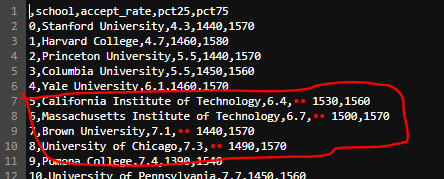

In [10]:
#read in CSV with corrected values for colleges 5-8
college2  = pd.read_csv('./data/out_edited.csv')
college2.drop(columns = 'Unnamed: 0', inplace = True)

#college['accept_rate'] = pd.to_numeric(college['accept_rate'])
college2.dtypes

school          object
accept_rate    float64
pct25          float64
pct75            int64
dtype: object

In [11]:
college2.head()

,school,accept_rate,pct25,pct75
0,Stanford University,4.3,1440.0,1570
1,Harvard College,4.7,1460.0,1580
2,Princeton University,5.5,1440.0,1570
3,Columbia University,5.5,1450.0,1560
4,Yale University,6.1,1460.0,1570


### Now our data types are ok and were ready for analysis

In [12]:
percent_colleges_25_pct_over_1000 = round(college2[college2['pct25'] > 1010].shape[0]/college2.shape[0],5)
print(percent_colleges_25_pct_over_1000)
print('90% of colleges 25th percentile is over 1010 points. 1010 points is the sum of the 2020 minimum benchmarks for math and writing')

0.9
90% of colleges 25th percentile is over 1010 points. 1010 points is the sum of the 2020 minimum benchmarks for math and writing


In [13]:
from sklearn.linear_model import LinearRegression

# Instantiate
lr = LinearRegression()

#set X equal to accept rate
X = college2[['accept_rate']]

#set y = pct25
y = college2['pct25']

#Assert that the shapes are correct for the regression
assert X.shape[0] == y.shape[0]

# fit
lr.fit(X, y)

slope = lr.coef_
print('Slope:', slope)

intercept = lr.intercept_
print('Intercept:', intercept)


Slope: [-4.28467039]
Intercept: 1404.0981598286335


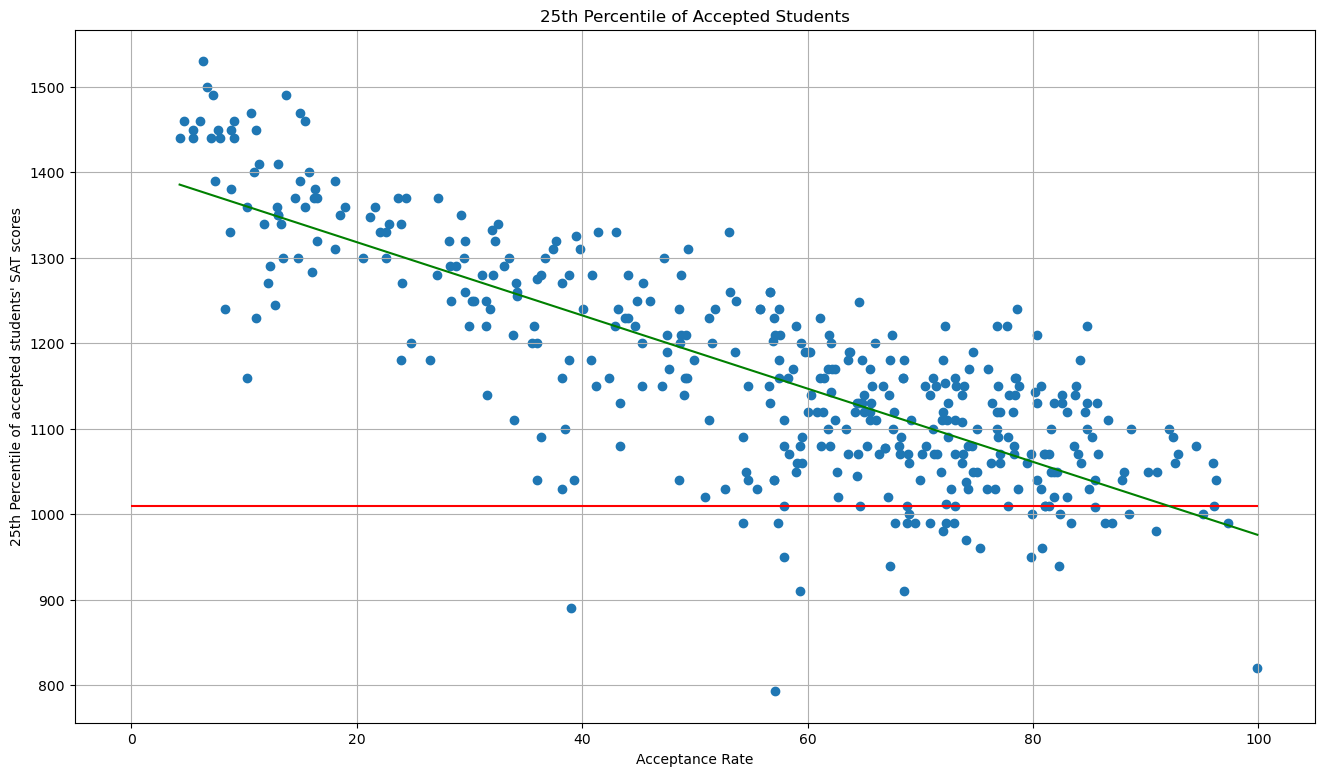

In [14]:
#create plot
myfig = plt.figure(figsize = (16,9))
plt.scatter(college2['accept_rate'], college2['pct25'])
plt.grid()
plt.title('25th Percentile of Accepted Students')
plt.xlabel('Acceptance Rate')
plt.ylabel('25th Percentile of accepted students\' SAT scores')
plt.xticks(rotation = 0)
plt.hlines(1010,0,100, color = 'red')
plt.plot(X, intercept + slope * X, '-', color = 'green')
plt.savefig('25pct.png', bbox_inches = 'tight', dpi=myfig.dpi);

This scatter plot shows an inverse relationship between accepance rate (our approximation for school quality) and the 25th percentile of accepted students' SAT scores. The slope of the green regression line is -4.28, which means that a 1% increase in acceptance rate would predict a 4.28 point reduction in the 25th percentile SAT score.

The red horizontal line is at 1010 points. That is the sum of the [College Board's](https://collegereadiness.collegeboard.org/about/scores/benchmarks) official benchmarks for math and writing as of 2020. I've plotted this line to help us relate to my earlier discussion which revolved around benchmarks as opposed to raw scores. 

90% of colleges' 25th percentile SAT score is above the 1010 point line. This means that a student failing to exceed the 1010 point benchmarks could be a signifigant obstacle for their college acceptance, especially for colleges with lower acceptance rates.

The good news is that many colleges (even into the lower acceptance rates) have a 25th percentile SAT score below 1100. Once students exceed the 1010 point line their opportunities quickly improve. Looking again at the regression line, if a student increases their SAT score from 1000 points to 1100 points our model would predict they could get into the second quantile of a college with an acceptance rate 23% 'harder'. 

In [15]:
# Instantiate
lr = LinearRegression()

#set X equal to accept rate
X = college2[['accept_rate']]

#set y = pct25
y = college2['pct75']

assert X.shape[0] == y.shape[0]
# fit
lr.fit(X, y)

slope = lr.coef_
print('Slope:', slope)

intercept = lr.intercept_
print('Intercept:', intercept)

Slope: [-3.53448611]
Intercept: 1554.4713168154694


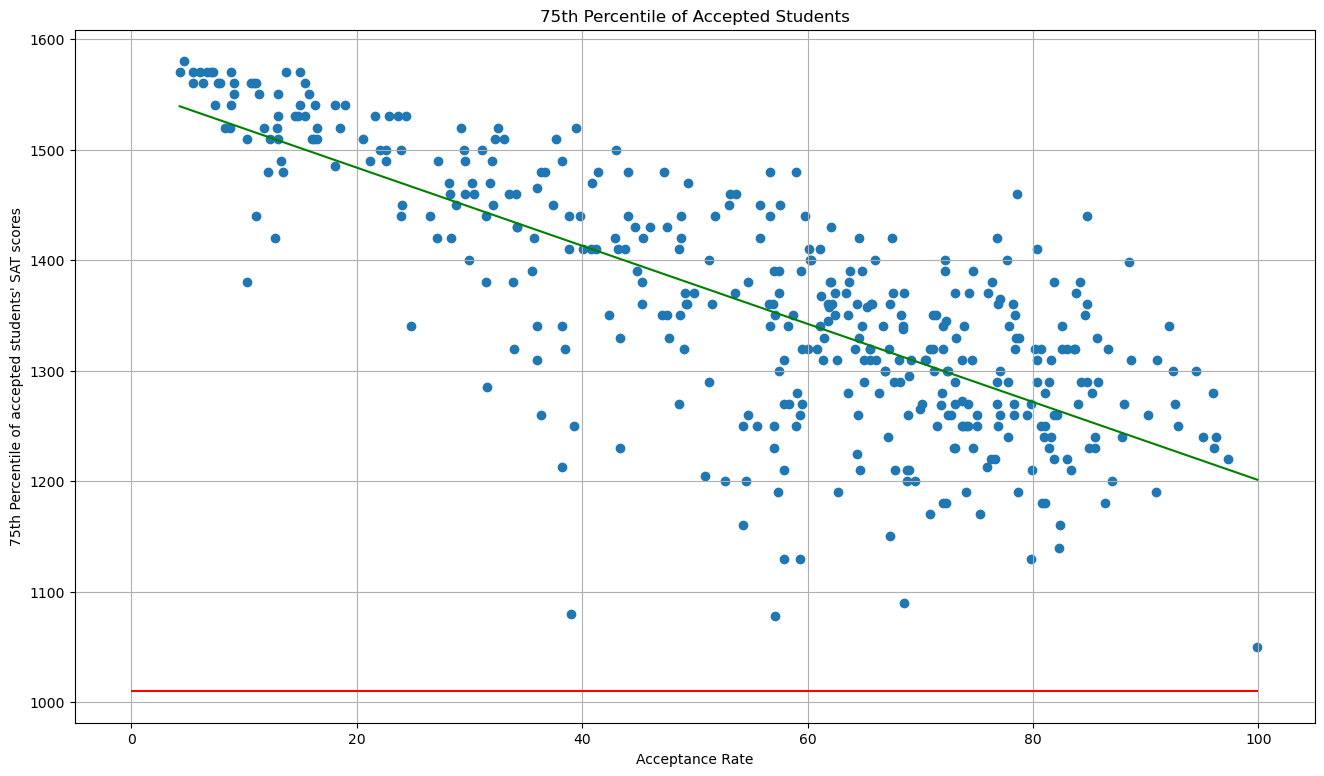

In [16]:
#create plot
myfig = plt.figure(figsize = (16,9))
plt.scatter(college2['accept_rate'], college2['pct75'])
plt.grid()
plt.title('75th Percentile of Accepted Students')
plt.xlabel('Acceptance Rate')
plt.ylabel('75th Percentile of accepted students\' SAT scores')
plt.xticks(rotation = 0)
plt.hlines(1010,0,100, color = 'red')
plt.plot(X, intercept + slope * X, '-', color = 'green')
plt.savefig('75pct.png', bbox_inches = 'tight', dpi=myfig.dpi);

Here is the corresponding graph for the 75th percentile of accepted students' SAT scores. Compared to the 25th percentile, this graph isn't as relevant to our analysis. We are focused on how we can get students' SAT scores over the minimum benchmarks, into the second quantile of SAT scores, and into college. 

One takeaway from this graph is that there is not a single college with a 75th percentile below 1010.

In [73]:
#create column with the difference between the 25th and 75th percentile of accepted students
college2['range25to75pct'] = college2['pct75']-college2['pct25']

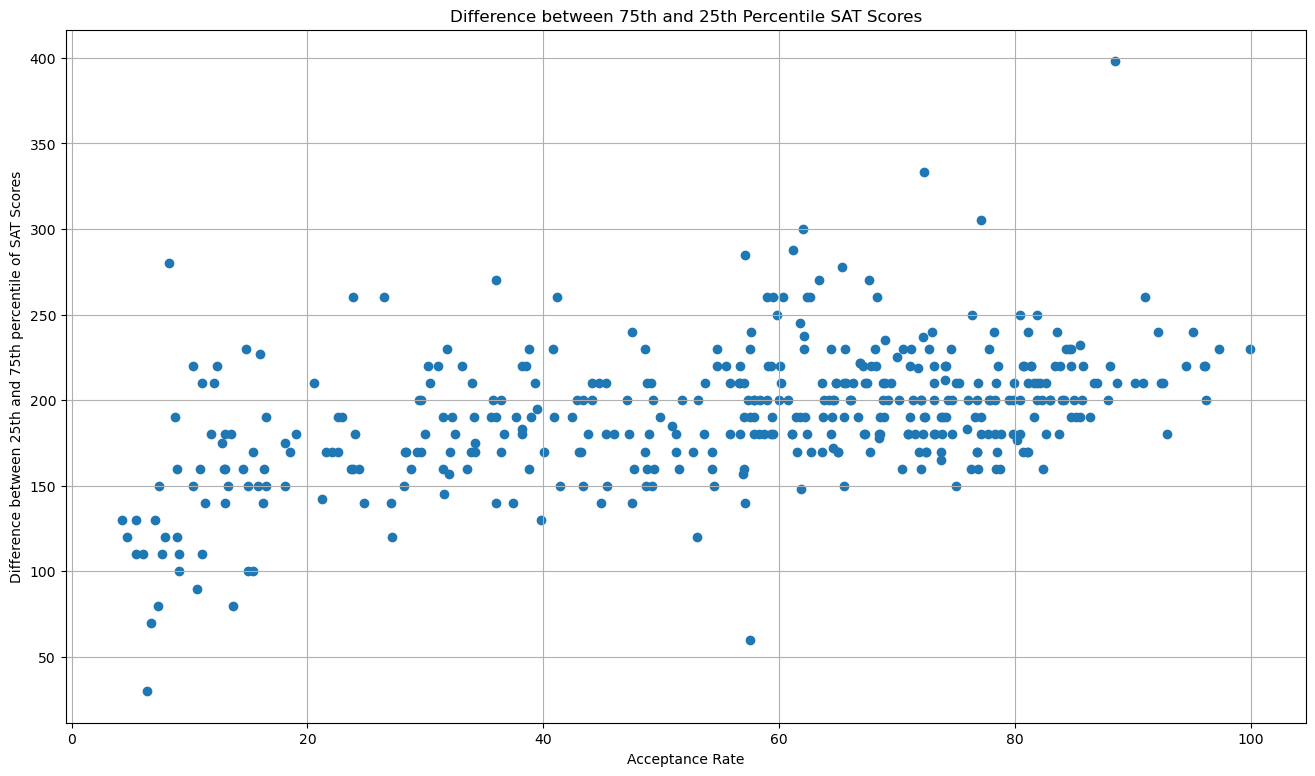

In [75]:
#create plot
myfig = plt.figure(figsize = (16,9))
plt.scatter(college2['accept_rate'], college2['range25to75pct'])
plt.title('Difference between 75th and 25th Percentile SAT Scores')
plt.grid()
plt.xlabel('Acceptance Rate')
plt.ylabel('Difference between 25th and 75th percentile of SAT Scores')
plt.savefig('rangepct.png', bbox_inches = 'tight', dpi=myfig.dpi);

I made this plot because I expected to see a reduction in the difference between the 25th and 75th percentiles as acceptance rate went down. For a selective university like Stanford, I figured all accepted students would have done very well on the SAT so the range would be very low.

The plot shows that there is a very weak relationship between acceptance rate and the range between the percentiles. I have elected to not add the regression line because I believe the correlation is too weak to imply that the regression line is useful for predictive purposes.

## Part 3: Address SAT prep classes as a possible solution for underperforming counties

Studying the effectiveness of SAT prep classes falls outside the scope of this analysis. Please see the readme and the presentation for the information I've collected from outside sources on the effectiveness of SAT prep courses